In [2]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0, "../")
sys.path.insert(0,"../pompjax/pompjax/")

from global_config import config

results_dir           = config.get_property('results_dir')
results2_dir          = config.get_property('results2_dir')

data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]

from abm_utils import empirical_prevalence, simulate_abm, create_obs_infer
from utils_local.misc import amro2title, amro2cute


/Users/chaosdonkey06/conda/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
dates_simulation = pd.date_range(start="2020-02-01", end="2021-02-28", freq="D")

movement_df                  = pd.read_csv(os.path.join(data_db_dir, "long_files_8_25_2021", 'patient_movement_2022-Nov.csv'), parse_dates=['date']).drop_duplicates(subset=["date", "mrn"], keep="first")
movement_df["ward_total"]    = movement_df.apply(lambda x: x["ward"]+"-"+x["building"]+"-"+x["place"], axis=1)
movement_df                  = movement_df[movement_df["date"].isin(dates_simulation)]

mrd2id                       = {mrn: id for id, mrn in enumerate(movement_df.mrn.unique())}
ward2id                      = {ward_name: id for id, ward_name in enumerate(np.sort(movement_df.ward_total.unique()))}

movement_df["mrn_id"]        = movement_df.mrn.map(mrd2id)
movement_df["ward_id"]       = movement_df.ward_total.map(ward2id)

ward_size_df                 = movement_df.reset_index()
ward_size_df["ward_id"]      = ward_size_df["ward_total"].apply(lambda x: ward2id[x])
ward_size_df["num_patients"] = 1
ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])
ward_size_df                 = ward_size_df.groupby(["ward", "ward_id"]).mean().reset_index().sort_values(by="num_patients")
ward2size                    = {r.ward_id: r.num_patients for idx_r, r in ward_size_df.iterrows()}

id2ward                      = dict((v, k) for k, v in ward2id.items())

###-###-###-###-###-###-###-###-###-###-###-###

selected_buildings = ['Allen Hospital-Allen', 'Harkness Pavilion-Columbia', 'Milstein Hospital-Columbia', 'Mschony-Chony', 'Presbyterian Hospital-Columbia']
building2id        = {selected_buildings[i]: i for i in range(len(selected_buildings))}

def building2observation(building):
    if building in selected_buildings:
        return building2id[building]
    else:
        return 5

ward_names                   = np.sort(list(movement_df.ward_total.unique()))
ward_names_df                = pd.DataFrame(ward_names, columns=["ward"])
ward_names_df                = pd.DataFrame(ward_names, columns=["ward"])
ward_names_df["building"]    = ward_names_df["ward"].apply(lambda x: "-".join(x.split("-")[1:]))
ward_names_df["buidling_id"] = ward_names_df["building"].apply(lambda x: building2observation(x) )
ward_names_df["ward_id"]     = ward_names_df.apply(lambda x: np.where(ward_names_df.ward == x.ward)[0][0], axis=1)

###-###-###-###-###-###-###-###-###-###-###-###

selected_buildings     = ['Allen Hospital-Allen', 'Harkness Pavilion-Columbia', 'Milstein Hospital-Columbia', 'Mschony-Chony', 'Presbyterian Hospital-Columbia']
building2id            = {selected_buildings[i]: i for i in range(len(selected_buildings))}
wardid2buildingid      = {row.ward_id: row.buidling_id for i, row in ward_names_df.iterrows()}
movement_df["cluster"] = movement_df.ward_id.map(wardid2buildingid)

<ipython-input-3-8d12fd2d6739>:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])


In [4]:
gammas_search = [0.25, 0.5]
betas_search  = [0.01, 0.05, 0.1]
rho_search    = [1/100, 5/100, 10/100, 18/100]

idx_sce = 0
scenarios_large_df = pd.DataFrame(columns=["scenario", "gamma", "beta", "rho"])
for g in gammas_search:
    for b in betas_search:
        for r in rho_search:
            scenarios_large_df = scenarios_large_df.append({"scenario": f"scenario{int(idx_sce+1)}", "gamma": g, "beta": b, "rho": r}, ignore_index=True)
            idx_sce += 1


<ipython-input-4-22d15ade080f>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scenarios_large_df = scenarios_large_df.append({"scenario": f"scenario{int(idx_sce+1)}", "gamma": g, "beta": b, "rho": r}, ignore_index=True)
<ipython-input-4-22d15ade080f>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scenarios_large_df = scenarios_large_df.append({"scenario": f"scenario{int(idx_sce+1)}", "gamma": g, "beta": b, "rho": r}, ignore_index=True)
<ipython-input-4-22d15ade080f>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scenarios_large_df = scenarios_large_df.append({"scenario": f"scenario{int(idx_sce+1)}", "gamma": g, "beta": b, "rho": r}, ignore_index=True)
<ipython-input-4-22d15ade080f>:10: FutureWarning: The frame.appe

In [5]:
from models import amr_abm, observe_cluster_individual

if_settings = {
        "Nif"                : 30,          # number of iterations of the IF
        "type_cooling"       : "geometric", # type of cooling schedule
        "shrinkage_factor"   : 0.9,         # shrinkage factor for the cooling schedule
        "inflation"          : 1.01         # inflation factor for spreading the variance after the EAKF step
        }

dates_simulation = pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="D")

model_settings   = {
                    "m"                 : 200,
                    "p"                 : 2,
                    "n"                 : movement_df.mrn_id.unique().shape[0],
                    "k"                 : movement_df.cluster.unique().shape[0],
                    "dates"             : pd.date_range(start="2020-02-01", end="2021-02-28", freq="D"),
                    "dates_simulation"  : pd.date_range(start="2020-02-01", end="2021-02-28", freq="D"),
                    "T"                 : len(dates_simulation),  # time to run
                    "num_build"         : len(np.unique(list(wardid2buildingid.values()))),
                    "k"                 : len(np.unique(list(wardid2buildingid.values())))# observing at the building aggregation
                }

assim_dates                       = list(pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="W-Sun"))
assim_dates[-1]                   = dates_simulation[-1]
if_settings["assimilation_dates"] = assim_dates
id_run                            = 0


In [6]:
from utils_local.misc import amro2title, amro2cute
from abm_utils import run_amro_synthetic
import matplotlib.pyplot as plt


for idx_row, row in scenarios_large_df.iterrows():

    path_to_save = os.path.join(results2_dir, "synthetic_inferences", "abm", "large_search", row["scenario"])
    os.makedirs(path_to_save, exist_ok=True)

    gamma = row["gamma"]

    print(f"\t Synthetic {idx_row+1}/{len(scenarios_large_df)}", end="\r")
    model_settings["param_truth"]     = [row["rho"], row["beta"]]
    if_settings["adjust_state_space"] = False
    if_settings["shrink_variance"]    = False

    path_to_samples = os.path.join(path_to_save, "infer_building", f"scenario{idx_row+1}")
    os.makedirs(path_to_samples, exist_ok=True)

    if os.path.isfile(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}posterior.npz")):
        continue

    model_settings["param_truth"]     = [row["rho"], row["beta"]]


    alpha               = 1/120
    init_state          = lambda θ: amr_abm(t = 0,
                                            agents_state   = np.zeros((model_settings["n"], model_settings["m"])),
                                            gamma          = gamma,
                                            beta           = θ[1, :],
                                            alpha          = alpha,
                                            movement       = movement_df[movement_df["date"]==dates_simulation[0]],
                                            ward2size      = ward2size,
                                            model_settings = model_settings)

    process       = lambda t, x, θ: amr_abm(t = t,
                                            agents_state   = x,
                                            gamma          = gamma,
                                            beta           = θ[1, :],
                                            alpha          = alpha,
                                            movement       = movement_df[movement_df["date"]==dates_simulation[t]],
                                            ward2size      = ward2size,
                                            model_settings = model_settings)

    obs_model = lambda t, x, θ: observe_cluster_individual(t = t,
                                                            agents_state   = x,
                                                            rho            = θ[0, :],
                                                            movement       = movement_df[movement_df["date"]==dates_simulation[t]],
                                                            model_settings = model_settings)

    run_amro_synthetic(f               = process,
                        f0             = init_state,
                        g              = obs_model,
                        fsim           = simulate_abm,
                        model_settings = model_settings,
                        if_settings    = if_settings,
                        id_run         = id_run,
                        path_to_save   = path_to_samples)


In [7]:
path_to_save_fig = os.path.join(results2_dir, "synthetic_inferences", "abm", "large_search", "figures")

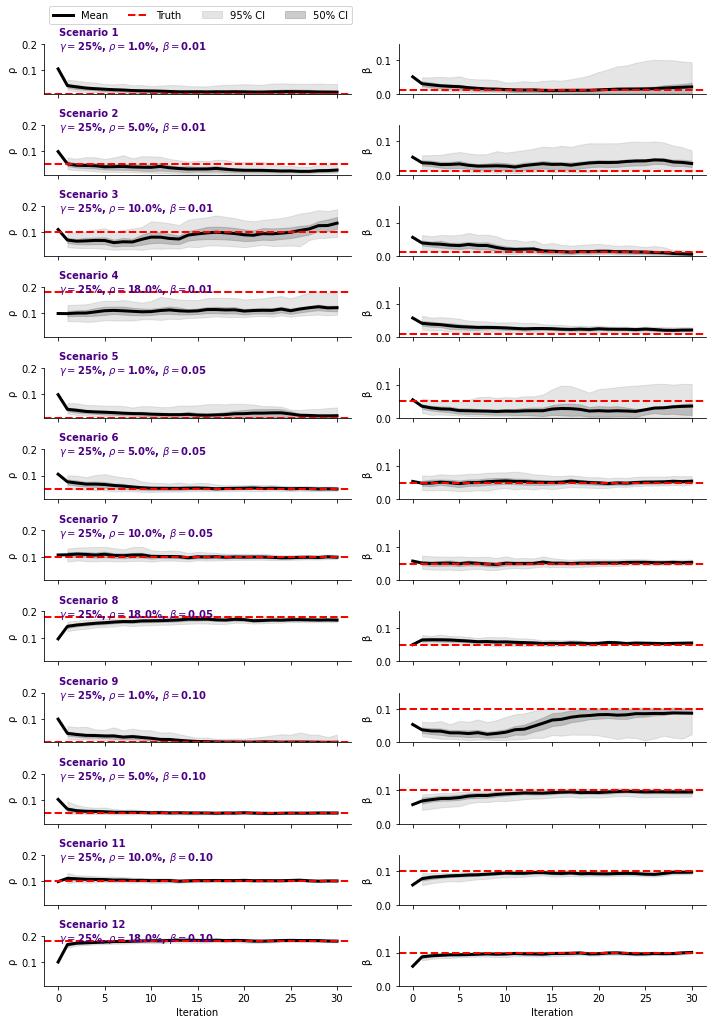

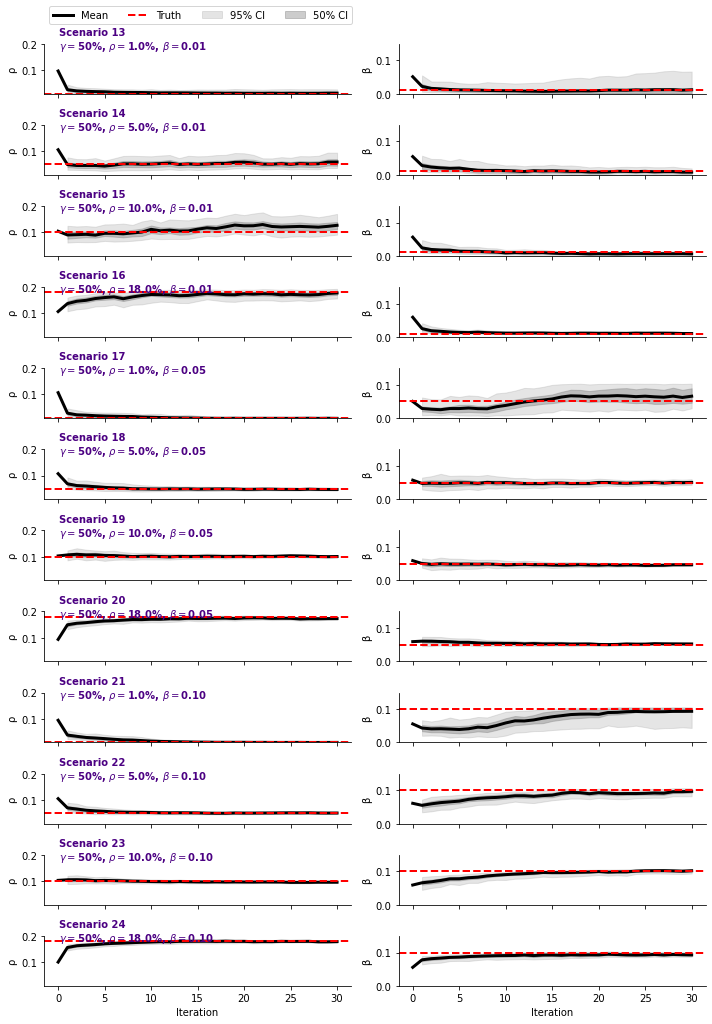

In [8]:
from diagnostic_plots import convergence_plot
from utils import create_df_response


gammas = [0.25, 0.50]

for gamma in gammas:
    sce_df = scenarios_large_df[scenarios_large_df.gamma==gamma]
    i_ax   = 0
    fig, axes = plt.subplots(len(sce_df), 2, figsize=(10, 14.2), sharex=True, sharey="col")
    for idx_row, row in sce_df.iterrows():

        path_to_samples   = os.path.join(results2_dir, "synthetic_inferences", "abm", "large_search", row["scenario"], "infer_building", f"scenario{idx_row+1}")
        samples_inference = np.load(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}posterior.npz"))

        θpost = samples_inference["posterior"]
        θmle  = samples_inference["mle"]
        Nif   = θpost.shape[-1]
        θpost = θpost[:, :, :, :].mean(-2)

        ρ_df = create_df_response(θpost[0, :, :].T, time=Nif)
        β_df = create_df_response(θpost[1, :, :].T, time=Nif)

        p_dfs       = [ρ_df, β_df]
        param_label = ["ρ", "β"]
        p_truth     = [row.rho, row.beta]

        parameters_range  = np.array([[0.01, 20/100], [0, 0.15]])
        convergence_plot(θmle, p_dfs, parameters_range, param_label, ax=axes[i_ax, :], fig=fig, param_truth=p_truth)
        axes[i_ax, 0].legend().remove(); axes[i_ax, 1].legend().remove()
        axes[i_ax, 1].set_xlabel(None)
        axes[i_ax, 0].spines['right'].set_visible(False)
        axes[i_ax, 0].spines['top'].set_visible(False)

        axes[i_ax, 1].spines['right'].set_visible(False)
        axes[i_ax, 1].spines['top'].set_visible(False)
        axes[i_ax, 0].text(x=0.1, y=0.18,
                        s=f"Scenario {idx_row+1} \n"+r"$\gamma=${:0.0f}%, $\rho=${:0.1f}%, $\beta=${:0.2f}".format(row.gamma*100, row.rho*100, row.beta),
                            weight='bold',
                            color="indigo")
        i_ax += 1

    axes[0, 0].legend(loc="upper left", bbox_to_anchor=(0.0, 1.85), ncol=4)
    axes[-1, 0].set_xlabel("Iteration")
    axes[-1, 1].set_xlabel("Iteration")

    fig.savefig(os.path.join(path_to_save_fig, "convergence_plots_gamma{}.png".format(gamma)), dpi=300, bbox_inches='tight', transparent=True)


In [9]:
posterior_df = pd.DataFrame()

for idx_row, row in scenarios_large_df.iterrows():

    path_to_samples = os.path.join(results2_dir, "synthetic_inferences", "abm", "large_search", row["scenario"], "infer_building", f"scenario{idx_row+1}")
    inference       = np.load(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}posterior.npz"))

    θmle      = inference["mle"]
    θpost     = inference["posterior"]
    y_sim     = inference["observations"]
    θtruth    = inference["teta_truth"]
    idx_infer = inference["idx_infer"]
    Nif       = θpost.shape[-1]

    ρ_post = θpost[0, :, :, :].mean(-2).flatten()
    β_post = θpost[1, :, :, :].mean(-2).flatten()

    post_df                = pd.DataFrame(columns=["value", "param", "ens_id", "if_iter"])
    post_df["value"]       = np.concatenate([ρ_post, β_post])
    post_df["value_truth"] = np.concatenate([θtruth[0, 0]*np.ones_like(ρ_post), θtruth[1, 0]*np.ones_like(β_post)])

    post_df["param"]    = ["ρ"] * len(ρ_post) + ["β"] * len(β_post)
    post_df["if_iter"]  = flatten_list([list(range(Nif)) * model_settings["m"] ] * 2 )
    post_df["ens_id"]   = flatten_list([[i] * Nif for i in range( model_settings["m"])] * 2)
    post_df["gamma"]    = row.gamma
    post_df["scenario"] = idx_row

    posterior_df        = pd.concat([posterior_df, post_df])

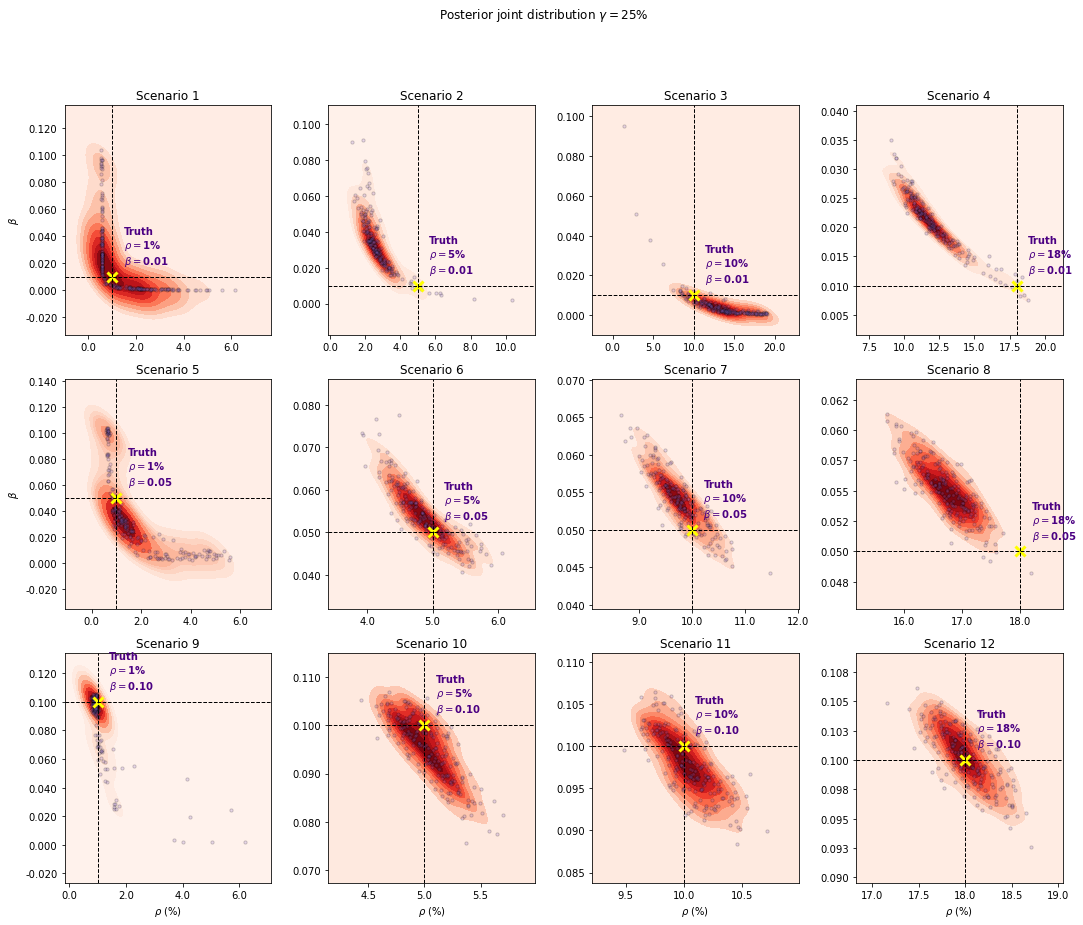

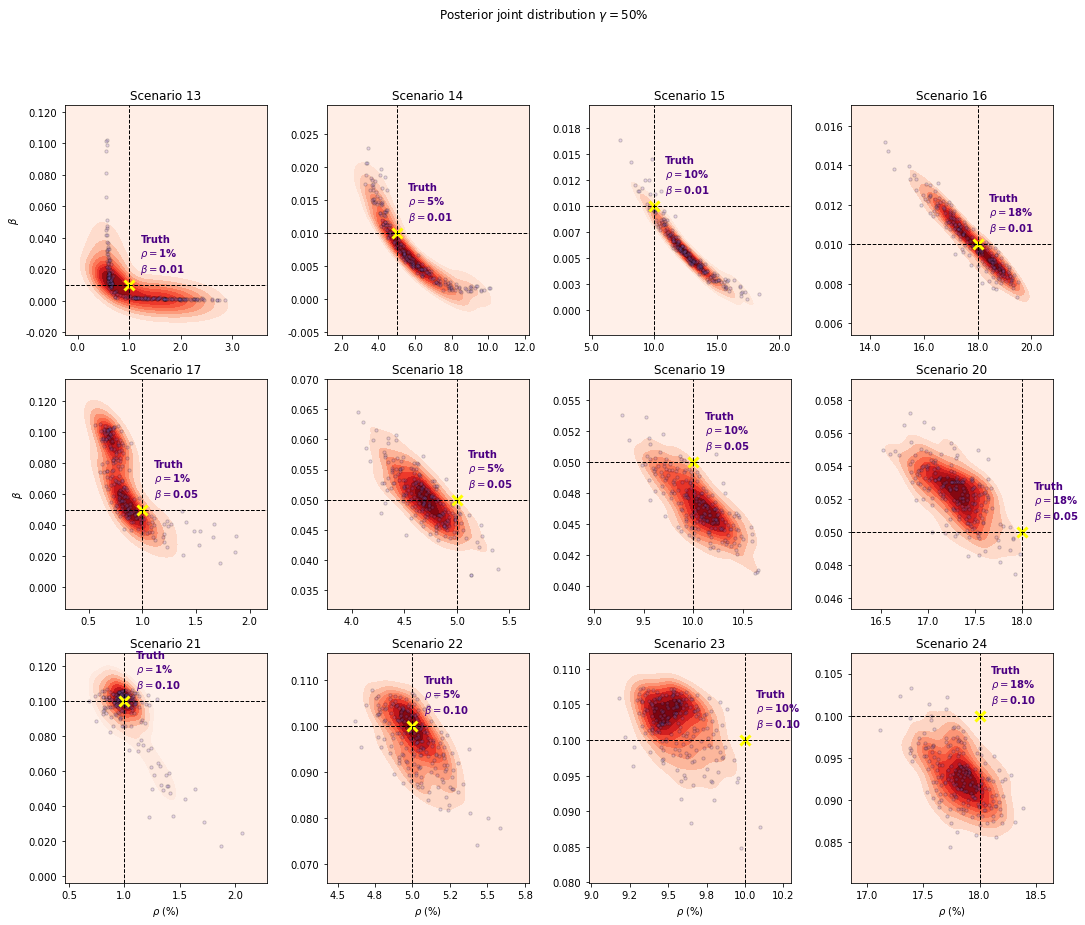

In [10]:
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
import seaborn as sns

v_df = posterior_df[posterior_df["if_iter"] == Nif-1]

for idx_gamma, gamma in enumerate([0.25, 0.5]):

    fig, axes = plt.subplots(3, 4, figsize=(15.2, 12.2), sharey=False, sharex=False)
    for idx_scenario, ax in enumerate(axes.flatten()):
        p_df             = v_df[v_df.gamma==gamma]
        p_df             = p_df[p_df["scenario"] == p_df["scenario"].unique()[idx_scenario]]
        rho_df           = p_df[p_df["param"] == "ρ"].reset_index(drop=True)
        beta_df          = p_df[p_df["param"] == "β"].reset_index(drop=True)
        rho_df["value"]  = rho_df["value"] * 100

        sns.kdeplot(ax    = ax,
                    x     = rho_df["value"],
                    y     = beta_df["value"],
                    cmap  = "Reds",
                    fill  = True,  thresh=0)

        ax.scatter(x          = rho_df["value"],
                    y         = beta_df["value"],
                    facecolor = "mediumpurple",
                    edgecolor = "k", alpha=0.2, s=10)

        ax.axhline(y=beta_df["value_truth"].drop_duplicates().values[0], color="k", lw=1, ls="--")
        ax.axvline(x=rho_df["value_truth"].drop_duplicates().values[0] * 100, color="k", lw=1, ls="--")

        ax.scatter(x          = rho_df["value_truth"].drop_duplicates()*100,
                    y         = beta_df["value_truth"].drop_duplicates(),
                    marker    = "x",
                    facecolor = "yellow",
                    lw        = 3,
                    s         = 100)

        ax.text(x = rho_df["value_truth"].drop_duplicates().values[0] * 100 + np.diff(ax.get_xlim())/18,
                y = beta_df["value_truth"].drop_duplicates().values[0]+ np.diff(ax.get_ylim())/18,
                s = "Truth\n"+r"$\rho=${:0.0f}%".format(rho_df["value_truth"].drop_duplicates().values[0]*100,) +"\n"+
                        r"$\beta=${:0.2f}".format(beta_df["value_truth"].drop_duplicates().values[0]),
                weight='bold', color="indigo")

        #ax.xaxis.set_major_formatter(mtick.PercentFormatter())
        ax.set_title("Scenario {}".format(p_df.scenario.unique()[0]+1))
        ax.set_xlabel(None)
        ax.set_ylabel(None)

    fig.suptitle("Posterior joint distribution $\gamma=${:0.0f}%".format(gamma*100), x=0.5, y=1.05)

    axes[0, 0].set_ylabel(r"$\beta$")
    axes[1, 0].set_ylabel(r"$\beta$")

    for i in range(4):
        axes[-1, i].set_xlabel(r"$\rho$ (%)")

    for axi in axes.flatten():
        axi.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))
        axi.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
    plt.tight_layout()

    fig.savefig(os.path.join(path_to_save_fig, "joint_distribution_gamma{}.png".format(gamma)), dpi=300, bbox_inches='tight', transparent=True)


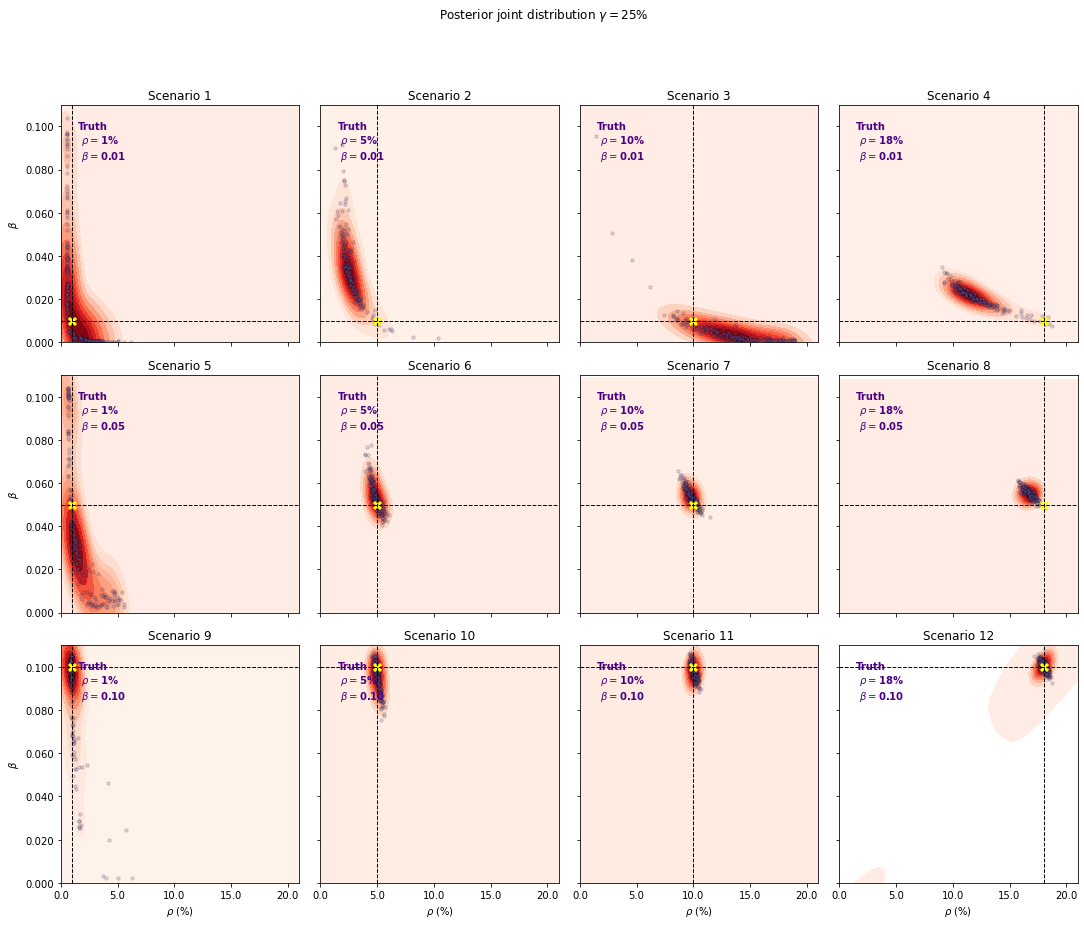

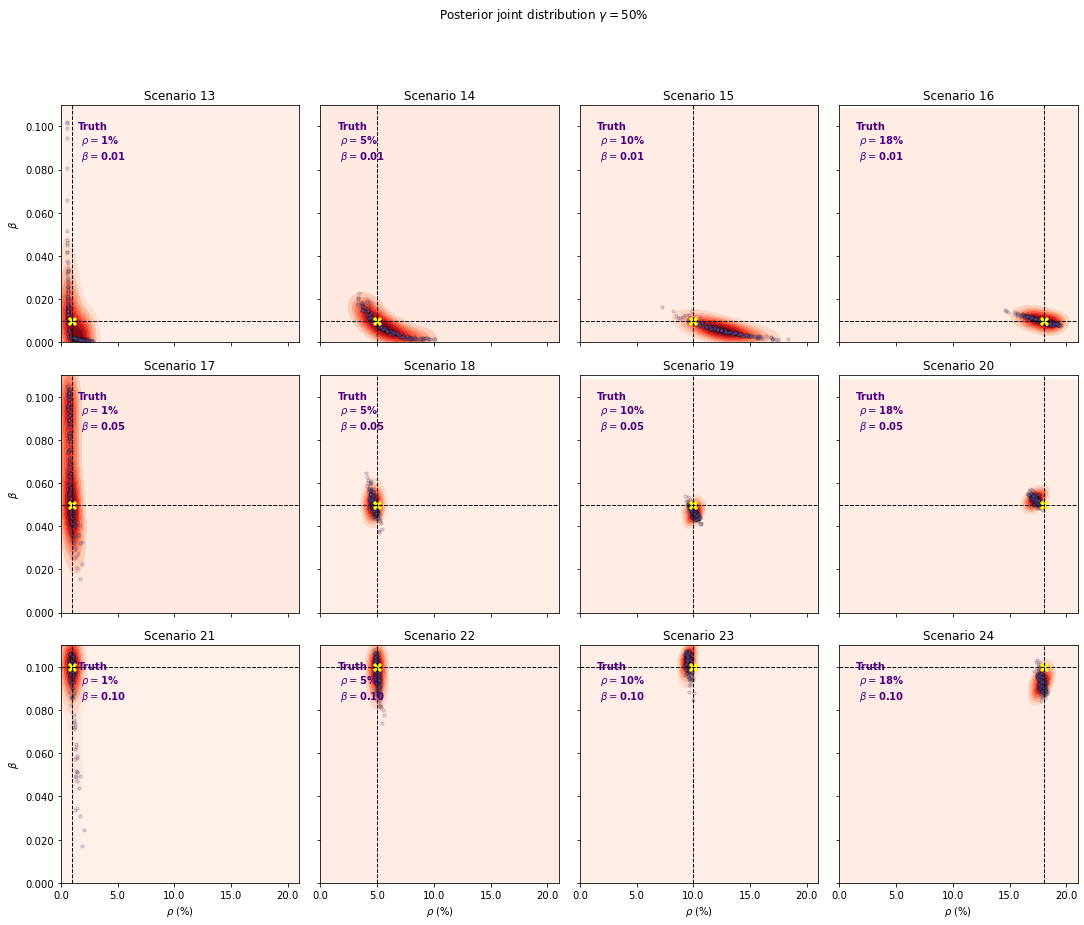

In [63]:
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
import seaborn as sns

v_df = posterior_df[posterior_df["if_iter"] == Nif-1]

for idx_gamma, gamma in enumerate([0.25, 0.5]):

    fig, axes = plt.subplots(3, 4, figsize=(15.2, 12.2), sharey=True, sharex=True)
    for idx_scenario, ax in enumerate(axes.flatten()):
        p_df             = v_df[v_df.gamma==gamma]
        p_df             = p_df[p_df["scenario"] == p_df["scenario"].unique()[idx_scenario]]
        rho_df           = p_df[p_df["param"] == "ρ"].reset_index(drop=True)
        beta_df          = p_df[p_df["param"] == "β"].reset_index(drop=True)
        rho_df["value"]  = rho_df["value"] * 100

        sns.kdeplot(ax    = ax,
                    x     = list(rho_df["value"].values) + [0, 20],
                    y     = list(beta_df["value"])       + [-0.02, 0.1],
                    cmap  = "Reds",
                    fill  = True,  thresh=0)

        ax.scatter(x          = rho_df["value"],
                    y         = beta_df["value"],
                    facecolor = "mediumpurple",
                    edgecolor = "k", alpha=0.2, s=10)

        ax.axhline(y=beta_df["value_truth"].drop_duplicates().values[0], color="k", lw=1, ls="--")
        ax.axvline(x=rho_df["value_truth"].drop_duplicates().values[0] * 100, color="k", lw=1, ls="--")

        ax.scatter(x          = rho_df["value_truth"].drop_duplicates()*100,
                    y         = beta_df["value_truth"].drop_duplicates(),
                    marker    = "x",
                    facecolor = "yellow",
                    lw        = 3,
                    s         = 50)

        ax.text(x = 1.5,
                y = 0.085,
                s = "Truth\n"+r" $\rho=${:0.0f}%".format(rho_df["value_truth"].drop_duplicates().values[0]*100,) +"\n"+
                        r" $\beta=${:0.2f}".format(beta_df["value_truth"].drop_duplicates().values[0]),
                weight='bold', color="indigo")

        ylim = ax.get_ylim()
        ax.set_ylim((0, 0.11))
        ax.set_xlim((0, 21))

        #ax.xaxis.set_major_formatter(mtick.PercentFormatter())
        ax.set_title("Scenario {}".format(p_df.scenario.unique()[0]+1))
        ax.set_xlabel(None)
        ax.set_ylabel(None)

    fig.suptitle("Posterior joint distribution $\gamma=${:0.0f}%".format(gamma*100), x=0.5, y=1.05)

    axes[0, 0].set_ylabel(r"$\beta$")
    axes[1, 0].set_ylabel(r"$\beta$")
    axes[2, 0].set_ylabel(r"$\beta$")

    for i in range(4):
        axes[-1, i].set_xlabel(r"$\rho$ (%)")

    for axi in axes.flatten():
        axi.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))
        axi.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
    plt.tight_layout()
    fig.savefig(os.path.join(path_to_save_fig, "joint_distribution_gamma{}_2.png".format(gamma)), dpi=300, bbox_inches='tight', transparent=True)


<ipython-input-74-62d4a755ae25>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v_df["scenario_name"] = v_df["scenario"].map(lambda x: f"scenario{x+1}")


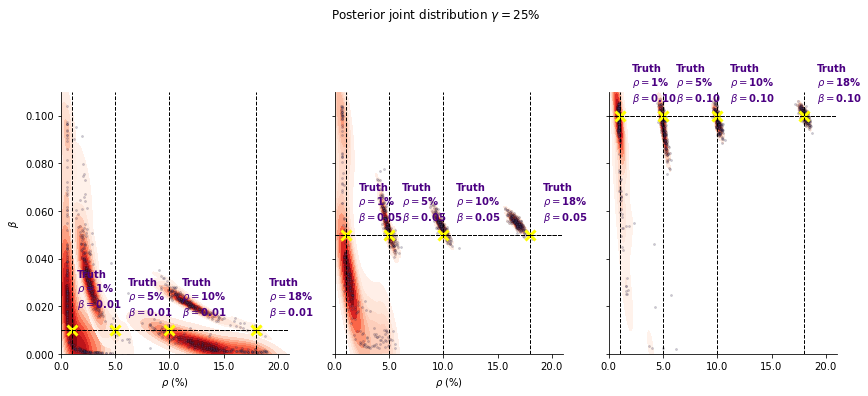

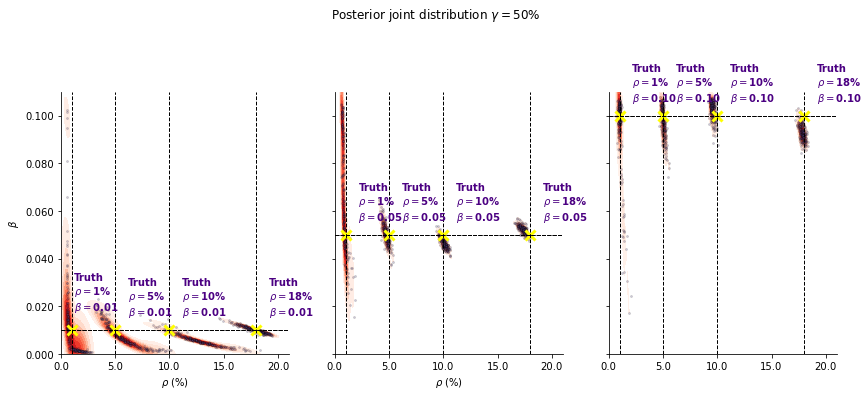

In [74]:
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
import seaborn as sns

v_df = posterior_df[posterior_df["if_iter"] == Nif-1]
v_df["scenario_name"] = v_df["scenario"].map(lambda x: f"scenario{x+1}")

for idx_gamma, gamma in enumerate([0.25, 0.5]):

    fig, axes = plt.subplots(1, 3, figsize=(12.2, 5.2), sharey=True, sharex=True)

    p_df             = v_df[v_df.gamma==gamma]
    ro_list   = p_df[["param", "value_truth"]].drop_duplicates().query("param=='ρ'")["value_truth"].values
    beta_list = p_df[["param", "value_truth"]].drop_duplicates().query("param=='β'")["value_truth"].values

    for idx_beta, beta in enumerate(beta_list):
        for idx_rho, rho in enumerate(ro_list):
            ax = axes[idx_beta]

            p_df             = v_df.query("scenario_name=='{}'".format(scenarios_large_df.query(f"gamma=={gamma} and beta=={beta} and rho=={rho}")["scenario"].values[0]))
            rho_df           = p_df.reset_index(drop=True).query(f"param=='ρ' and value_truth=={rho}")
            beta_df          = p_df.reset_index(drop=True).query(f"param=='β' and value_truth=={beta}")
            rho_df["value"]  = rho_df["value"] * 100

            sns.kdeplot(ax    = ax,
                        x     = rho_df["value"].values,
                        y     = beta_df["value"].values,
                        cmap  = "Reds",
                        fill  = True
                        )

            ax.scatter(x          = rho_df["value"],
                        y         = beta_df["value"],
                        facecolor = "mediumpurple",
                        edgecolor = "k", alpha=0.2, s=3)

            ax.axhline(y=beta_df["value_truth"].drop_duplicates().values[0], color="k", lw=1, ls="--")
            ax.axvline(x=rho_df["value_truth"].drop_duplicates().values[0] * 100, color="k", lw=1, ls="--")

            ax.scatter(x          = rho_df["value_truth"].drop_duplicates()*100,
                        y         = beta_df["value_truth"].drop_duplicates(),
                        marker    = "x",
                        facecolor = "yellow",
                        lw        = 3,
                        s         = 100)

            ax.text(x = rho_df["value_truth"].drop_duplicates().values[0] * 100 + np.diff(ax.get_xlim())/18,
                    y = beta_df["value_truth"].drop_duplicates().values[0]+ np.diff(ax.get_ylim())/18,
                    s = "Truth\n"+r"$\rho=${:0.0f}%".format(rho_df["value_truth"].drop_duplicates().values[0]*100,) +"\n"+
                            r"$\beta=${:0.2f}".format(beta_df["value_truth"].drop_duplicates().values[0]),
                    weight='bold', color="indigo")

            #ax.xaxis.set_major_formatter(mtick.PercentFormatter())
            #ax.set_title("Scenario {}".format(p_df.scenario.unique()[0]+1))

            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.set_ylim((0, 0.11))
            ax.set_xlim((0, 21))
            ax.set_xlabel(None)
            ax.set_ylabel(None)

    fig.suptitle("Posterior joint distribution $\gamma=${:0.0f}%".format(gamma*100), x=0.5, y=1.05)

    axes[0].set_ylabel(r"$\beta$")

    for i in range(2):
        axes[i].set_xlabel(r"$\rho$ (%)")

    for axi in axes.flatten():
        axi.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))
        axi.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
    plt.tight_layout()

    #fig.savefig(os.path.join(path_to_save_fig, "joint_distribution_gamma{}.png".format(gamma)), dpi=300, bbox_inches='tight', transparent=True)
